ДЗ по итогам лекции 8, задание 1.

Подготовить данные для модели:
    
   Анализ данных, необходимые корректировки. 
1. Обработать пропуски. 
2. Оценить выбросы. 
3. Корреляция. 
4. Тест на нормальность распределения.
5. Масштабировать данные.

Анализ задания: следует загрузить файл данных, представленный в формате csv, в датафрейм модуля pandas.
*) Далее следует провести поиск пропусков и удалить строки с пропусками.
*) Кроме того, предварительный анализ файла данных показывает, что колонка living region содержит много дублей типа "московская обл" и "обл московская" или "чеченская республика" и "чеченская респ". Придется поработать с данными этой колонки, чтобы привести систему обозначений регионов к однозначной. Поскольку регионов слишком много, что затруднит анализ корреляции данных, то мы приведем всю систему к федеральным округам и двум столицам - Москва и Санкт-Петербург.
*) Далее для оценки выбросов числовых данных следует провести оценку матожидания и дисперсии каждого столбца данных, представленного в численном виде. Все значения, отстоящие более чем на 3 выборочных стандартных отклонения, удаляем из массива данных (точнее, удаляем из выборки все объекты, для которых хотя бы в одном столбце имеются выбросы).
*) С помощью функций подключенной библиотек оценим нормальность распределений данных
*) В конце числовые колонки данных масштабируем, поделив на максимальный элемент каждой колонки

Загружаем данные.
Выводим для ознакомления заголовочную строку и первые пять строк. 

In [220]:
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder

data_table = pd.read_csv('credit_train.csv', sep = ';', decimal = ',', encoding = 'windows-1251')
print(f'Rows in the initial table: {len(data_table)}') 
print(data_table.head())
print(f'Data table shape: {data_table.shape}')

Rows in the initial table: 170746
   client_id gender   age marital_status job_position  credit_sum  \
0          1      M   NaN            NaN          UMN    59998.00   
1          2      F   NaN            MAR          UMN    10889.00   
2          3      M  32.0            MAR          SPC    10728.00   
3          4      F  27.0            NaN          SPC    12009.09   
4          5      M  45.0            NaN          SPC         NaN   

   credit_month tariff_id  score_shk education        living_region  \
0            10       1.6        NaN       GRD   КРАСНОДАРСКИЙ КРАЙ   
1             6       1.1        NaN       NaN               МОСКВА   
2            12       1.1        NaN       NaN      ОБЛ САРАТОВСКАЯ   
3            12       1.1        NaN       NaN    ОБЛ ВОЛГОГРАДСКАЯ   
4            10       1.1   0.421385       SCH  ЧЕЛЯБИНСКАЯ ОБЛАСТЬ   

   monthly_income  credit_count  overdue_credit_count  open_account_flg  
0         30000.0           1.0                   

Видим сразу много NaN. 
Это процедура загрузки заменила пропуски.
Такие строки подлежат устранению.
Удаляем строки c NaN (то есть с отсутствовавшими изначально значениями, которые при загрузке с помощью функции read_csv превратились в NaN) c помощью dropna:

In [221]:
data_table.dropna(inplace=True) # inplace means we change data_table itself, not create new modified one
print(data_table.head())
print(f'Размер таблицы {data_table.shape}')

    client_id gender   age marital_status job_position  credit_sum  \
7           8      F  26.0            UNM          SPC     47878.0   
9          10      F  32.0            UNM          SPC     26268.0   
10         11      M  26.0            MAR          SPC     16793.0   
12         13      M  37.0            MAR          SPC     42289.0   
13         14      M  43.0            MAR          INP     57567.0   

    credit_month tariff_id  score_shk education        living_region  \
7             10       1.1   0.512525       GRD       МОСКОВСКАЯ ОБЛ   
9             10       1.1   0.465026       GRD  КРАЙ СТАВРОПОЛЬСКИЙ   
10            14       1.0   0.445430       SCH      САНКТ-ПЕТЕРБУРГ   
12            10       1.6   0.691609       SCH    ОБЛ АРХАНГЕЛЬСКАЯ   
13            10       1.1   0.341164       GRD  ХАНТЫ-МАНСИЙСКИЙ АО   

    monthly_income  credit_count  overdue_credit_count  open_account_flg  
7          60000.0           3.0                   0.0                 

Теперь следует обработать колонку living region. 
Поскольку регионов слишком много, работа сразу со всеми даст громоздкие результаты, анализ которых затруднен.
Даже Путину это было ясно еще в 2000 г., отчего вся территория России была им поделена на федеральные округа. 
На данный момент их восемь. Еще имеет смысл отдельно рассматривать Москву и Петербург, поскольку в социологическом плане они сильно отличаются от остальной России.
Поэтому мы объединим все регионы по федеральным округам плюс отдельно укажем Москву и Петербург. 
Получим ровно десять living regions:
1. Центральный ФО
2. Северо-Западный ФО
3. Южный ФО
4. Северо-Кавказский ФО
5. Приволжский  ФО
6. Уральский ФО
7. Сибирский ФО
8. Дальневосточный ФО
9. Москва
10. Санкт-Петербург

С таким количеством регионов уже можно работать.
Попутно отметим, что в таблице два раза встречается регион Россия. Придется его целенаправленно уничтожить.

In [222]:
# looking for the region 'Россия' and removing it:
indices = data_table.index[data_table['living_region'] == 'РОССИЯ']
for ind in indices:
    data_table = data_table.drop(index = ind)

# function returning the string replace_to if a data_cell contains a string from string_set
def replace_cell_value(data_cell, string_set, replace_to):
    for str in string_set:
        if str in data_cell:
            return replace_to            
    return data_cell # if no string in string_set is present in data_cell

# the regions of every federal district, keywords:
central_fo = ['БЕЛГОРОД', 'БРЯНСК', 'ВЛАДИМИР', 'ВОРОНЕЖ', 'ГУСЬ', 'ИВАНОВ', 'КАЛУГ', 'КАЛУЖ', 'КОСТРОМ', 'КУРСК', 'ЛИПЕЦК', 'МОСКОВСК', 'МЫТИЩ', 'ОРЕЛ', 'ОРЁЛ', 'ОРЛОВСК', 'РЯЗАН', 'СМОЛЕНСК', 'ТАМБОВ', 'ТВЕР', 'ТУЛА', 'ТУЛЬСК', 'ЯРОСЛАВ'] 
north_west_fo = ['КАРЕЛ','КОМИ','АРХАНГ','ВОЛОГ','КАЛИНИНГР','ЛЕНИНГР','МУРМАН','НОВГОРОД','ПСКОВ','НЕНЕЦК']
south_fo = ['АДЫГ','КАЛМЫК','КРЫМ','КРАСНОДАР','АСТРАХАН','ВОЛГОГРАД','РОСТОВ','СЕВАСТ']
caucas_fo =['ДАГЕСТ','ИНГУШ','КАБАРДИН','БАЛКАР','КАРАЧАЕВ','ЧЕРКЕС','ОСЕТИ','АЛАНИ','ЧЕЧЕН','ЧЕЧНЯ','СТАВРОПОЛ']
volga_fo = ['ПРИВОЛЖСК','БАШКИР','БАШКОР', 'ГОРЬКИЙ', 'ГОРЬКОВСК', 'МАРИЙ','МОРДОВ','ТАТАР','УДМУРТ','ЧУВАШ','ПЕРМ','КИРОВ','НИЖЕГОРОД','НИЖНИЙ','ОРЕНБУРГ','ПЕНЗ','САМАР','САРАТОВ','УЛЬЯН','СИМБИРС']
urals_fo =['ЕКАТЕРИНБ','СВЕРДЛОВ','КУРГАН','ТЮМЕН','ЧЕЛЯБ','ТАГИЛ','ХАНТЫ','МАНСИ','ЯМАЛ','НЕНЕЦ', '74']
siberia_fo = ['АЛТАЙ','ТЫВА','ТУВА','ТУВИН','ХАКАС','КРАСНОЯРСК','ИРКУТСК','КЕМЕРОВ','КУЗБАСС','НОВОСИБ','ОМСК', 'ЭВЕНК']
far_east_fo = ['ВЛАДИВОСТ','ХАБАРОВ','БУРЯТ','САХА','ЯКУТ','БАЙКАЛ','КАМЧАТ','ПРИМОРСК','АМУР','МАГАДАН','САХАЛИН','ЕВРЕЙ','ЧИТА', 'ЧИТИН', 'ЧУКОТ']
moskau = ['МОСКВ']
piter = ['ПЕТЕРБ', '98']
regions = [central_fo, north_west_fo, south_fo, caucas_fo, volga_fo, urals_fo, siberia_fo, far_east_fo, moskau, piter]

# regions to be put into dataset:
federal_districts = ['Центральный ФО', 'Северо-Западный ФО', 'Южный ФО', 'Северо-Кавказский ФО', 'Приволжский  ФО', 'Уральский ФО', 'Сибирский ФО', 'Дальневосточный ФО', 'Москва', 'Санкт-Петербург']

# Replacing the cells in living_region with federal districts
i = 0
for region in regions:
    data_table['living_region'] = data_table['living_region'].map(lambda x: replace_cell_value(x, region, federal_districts[i]))
    i += 1

# saving result for debugging purposes
# data_table.to_csv('tmp.csv', index = False, sep=';', decimal = ',', encoding = 'windows-1251') 
print(data_table.shape)
print(data_table.head())

(161329, 15)
    client_id gender   age marital_status job_position  credit_sum  \
7           8      F  26.0            UNM          SPC     47878.0   
9          10      F  32.0            UNM          SPC     26268.0   
10         11      M  26.0            MAR          SPC     16793.0   
12         13      M  37.0            MAR          SPC     42289.0   
13         14      M  43.0            MAR          INP     57567.0   

    credit_month tariff_id  score_shk education         living_region  \
7             10       1.1   0.512525       GRD        Центральный ФО   
9             10       1.1   0.465026       GRD  Северо-Кавказский ФО   
10            14       1.0   0.445430       SCH       Санкт-Петербург   
12            10       1.6   0.691609       SCH    Северо-Западный ФО   
13            10       1.1   0.341164       GRD          Уральский ФО   

    monthly_income  credit_count  overdue_credit_count  open_account_flg  
7          60000.0           3.0                   0

Все колонки делим на две категории - числовые и нечисловые. 
Числовые будут исследоваться на выбросы и затем проверяться на нормальность, затем нормироваться.
Нечисловые колонки кодируем энкодером OneHotEncoder.
Особняком стоит колонка open_account_flg - флаг, сигнализирующий, открыт ли счет. Имеет два значения 0 и 1, а значит, по факту это нечисловая колонка "Счет открыт" или "Счет закрыт".
Поэтому с ней возникает вопрос - стоит ли ее кодировать с помощью OneHotEncoder или нет. По виду она уже сейчас не отличается от любой колонки, получаемой на выходе OneHotEncoder, поэтому кодировать ее и превращать тем самым в две колонки не стоит.
Далее отсеиваем строки с выбросами (где значения отстоят больше чем на 3 стандартных отклонения от среднего).

In [225]:
# Column titles of categorical features
# though tariff_id consists from zeros and units, but is in fact non-numerical, since it is the tariff category:
categorical_features = ['gender', 'marital_status', 'job_position', 'education', 'tariff_id'] 
# Column titles of numerical features
numerical_features = ['credit_sum', 'credit_month', 'score_shk', 'monthly_income', 'credit_count', 'overdue_credit_count', 'open_account_flg']

# creating dataframe for encoded values. First including only numeric data there
data_table_encoded = data_table[numerical_features] # dataframe for encoded data set
print(f'Length of table: {len(data_table_encoded)}')
data_table_encoded.reset_index(drop=True, inplace = True) # changing series indices to incrementing values
print(data_table_encoded.head()) 

encoder = OneHotEncoder() # init encoder

# transform the categorical data using OneHotEncoder
for feature in categorical_features:
    # print(feature)
    tmp_data = encoder.fit_transform(data_table[[feature]]) # coded data is sparse matrix
    tmp_data = tmp_data.todense() # to usual matrix 
    # print(tmp_data)
    # extract the feature names for the encoded columns
    tmp_titles = encoder.get_feature_names_out([feature])
    # print(tmp_titles)
    tmp_df = pd.DataFrame(tmp_data, columns = tmp_titles)
    data_table_encoded.merge(tmp_df, how = 'left') # merging into the encoded dataframe 
    # print(f'Current table size: {data_table_encoded.shape}')

# adding numerical columns to the encoded dataframe:
data_table_encoded = pd.concat([data_table_encoded, data_table[numerical_features].reset_index()], axis = 1)
# for debugging only:
# print(data_table_encoded)


# calculating the means and standard deviations over the numerical columns
# removing outliers (i.e. leaving only rows withot outliers)
for feature in numerical_features:
    mean = data_table_encoded[feature].mean()
    std = data_table_encoded[feature].std()
    print(f'Feature: {feature}, mean: {mean}, std: {std}')
    # z_scores i.e. distance from the data value to mean, in std values
    z_scores = (data_table_encoded[feature] - mean) / std
    # if z_scores are > 3 the data is considered to be an outlier:
    data_table_encoded = data_table_encoded[z_scores <= 3]
    # print(f'Current table size: {data_table_encoded.shape}')

 
data_table_encoded.reset_index(drop=True, inplace = True) # changing final series indices to incrementing values
# for debugging only:
print(data_table_encoded.head())

Length of table: 161329
   credit_sum  credit_month  score_shk  monthly_income  credit_count  \
0     47878.0            10   0.512525         60000.0           3.0   
1     26268.0            10   0.465026         39500.0           7.0   
2     16793.0            14   0.445430         36000.0           2.0   
3     42289.0            10   0.691609         70000.0           1.0   
4     57567.0            10   0.341164         60000.0           7.0   

   overdue_credit_count  open_account_flg  
0                   0.0                 0  
1                   0.0                 0  
2                   0.0                 0  
3                   0.0                 0  
4                   0.0                 0  


MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

Расчет и визуализация корреляционной матрицы, только для числовых колонок:

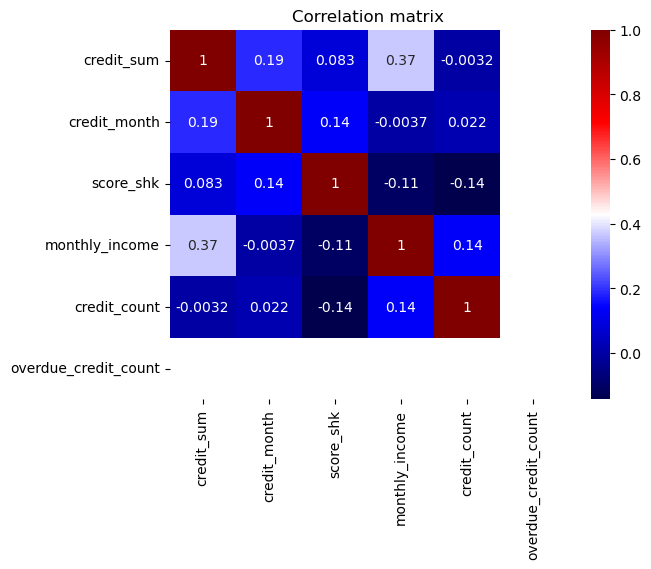

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# picking the numeric columns only: 
data_table_numeric = data_table_encoded[numerical_features]

corr = data_table_numeric.corr()
sns.heatmap(corr, annot = True, cmap = 'seismic')
plt.title("Correlation matrix")
plt.show()

Из корреляционной матрицы намечается положительная корреляция между суммой кредита и месячным доходом, и отрцаиельная корреляция между числом взятых кредитов и кредитным рейтингом гражданина

Тест на нормальность распределения.
Проверка с помощью теста Шапиро-Вилка в нашем случае не годится, поскольку для N>5000 практически всегда гипотеза нормального распределения отвергается. То есть в нашем случае почти наверняка результат будет отрицательным.
Но проверить не худо:

In [ ]:
from scipy.stats import shapiro
for feature in numerical_features:
    print(feature)
    # print(data_table_encoded[feature])
    s, p = shapiro(data_table_encoded[feature])
    print(f'The p-value is {p}')
    if p > 0.05:
        print(f'The null hypothesis (that the data came from a normally distributed population)\n can not be rejected for {feature}')
    else:
        print(f'There is evidence that the data in {feature} are not normally distributed')
      
    

credit_sum
The p-value is 2.1804362475518894e-123
There is evidence that the data in credit_sum are not normally distributed
credit_month
The p-value is 1.7360460900111226e-145
There is evidence that the data in credit_month are not normally distributed
score_shk
The p-value is 8.256280047753833e-55
There is evidence that the data in score_shk are not normally distributed
monthly_income
The p-value is 4.7514428869631823e-116
There is evidence that the data in monthly_income are not normally distributed
credit_count
The p-value is 3.183267735395715e-120
There is evidence that the data in credit_count are not normally distributed
overdue_credit_count
The p-value is 1.0
The null hypothesis (that the data came from a normally distributed population)
 can not be rejected for overdue_credit_count


c:\Users\User\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 143093.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\User\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Действительно, значения доверительной вероятности получились весьма малыми, и даже выскочило предупреждение о неприменимости теста.


Масштабировать данные - то есть поделить числовые колонки на их максимумы.
В финале сохранить полученные предобработанные данные для дальнейшего использования в какой-либо модели.

In [ ]:
for feature in numerical_features:
    data_table_encoded[feature] = data_table_encoded[feature] / data_table_encoded[feature].max()

data_table_encoded.to_csv('credit_train_preprocessed.csv', sep = ';', decimal = ',', encoding = 'windows-1251')   